In [7]:
# Importación de las bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [9]:
# Carga de datos
# Función para cargar y preparar los datos con manejo de excepciones
def cargar_datos(ruta_archivo):
    try:
        data = pd.read_csv(ruta_archivo)
        print(f"Carga exitosa del conjunto de datos {ruta_archivo}.")
        return data
    except FileNotFoundError:
        print(f"El archivo {ruta_archivo} no se encuentra en la ruta especificada.")
        return None

train_data = cargar_datos('files/datasets/input/gold_recovery_train.csv')
test_data = cargar_datos('files/datasets/input/gold_recovery_test.csv')
full_data = cargar_datos('files/datasets/input/gold_recovery_full.csv')

Carga exitosa del conjunto de datos files/datasets/input/gold_recovery_train.csv.
Carga exitosa del conjunto de datos files/datasets/input/gold_recovery_test.csv.
Carga exitosa del conjunto de datos files/datasets/input/gold_recovery_full.csv.


In [10]:
#  Realiza exploración y análisis exploratorio de datos
# Cálculo de la recuperación y EAM
# Verifica la presencia de columnas necesarias
required_columns = ['rougher.output.concentrate_au', 'rougher.input.feed_au',
                    'rougher.output.tail_au', 'rougher.output.recovery']

if all(column in train_data.columns for column in required_columns):
    # Define la función de cálculo de recuperación
    def recovery_calculation(C, F, T):
        recovery = (C * (F - T)) / (F * (C - T)) * 100
        recovery[recovery < 0] = np.nan  # Reemplaza valores negativos con NaN
        return recovery

    # Calcula la recuperación para rougher.output.recovery en el conjunto de entrenamiento
    recovery_train = recovery_calculation(train_data['rougher.output.concentrate_au'],
                                          train_data['rougher.input.feed_au'],
                                          train_data['rougher.output.tail_au'])

    # Calcula el EAM
    mae_recovery = np.mean(np.abs(train_data['rougher.output.recovery'] - recovery_train))
    print("EAM entre rougher.output.recovery y recuperación calculada:", mae_recovery)
else:
    print("Faltan columnas necesarias para el cálculo de recuperación.")

EAM entre rougher.output.recovery y recuperación calculada: 9.303415616264301e-15


In [11]:
# Análisis de características no disponibles en el conjunto de prueba
# Obtiene las columnas en el conjunto de entrenamiento y prueba
columns_train = set(train_data.columns)
columns_test = set(test_data.columns)

# Identifica las columnas no presentes en el conjunto de prueba
missing_columns = columns_train - columns_test

# Obtiene el tipo de cada columna no presente en el conjunto de prueba
column_types = {col: train_data[col].dtype for col in missing_columns}

# Imprime información sobre las características no disponibles en el conjunto de prueba
print("Características no disponibles en el conjunto de prueba:")
for col, dtype in column_types.items():
    print(f"Nombre: {col}, Tipo: {dtype}")

Características no disponibles en el conjunto de prueba:
Nombre: rougher.output.tail_pb, Tipo: float64
Nombre: rougher.calculation.floatbank11_sulfate_to_au_feed, Tipo: float64
Nombre: rougher.output.concentrate_au, Tipo: float64
Nombre: rougher.output.tail_ag, Tipo: float64
Nombre: final.output.tail_ag, Tipo: float64
Nombre: final.output.concentrate_sol, Tipo: float64
Nombre: final.output.tail_pb, Tipo: float64
Nombre: rougher.output.tail_au, Tipo: float64
Nombre: secondary_cleaner.output.tail_au, Tipo: float64
Nombre: primary_cleaner.output.concentrate_au, Tipo: float64
Nombre: primary_cleaner.output.concentrate_ag, Tipo: float64
Nombre: final.output.concentrate_ag, Tipo: float64
Nombre: final.output.concentrate_pb, Tipo: float64
Nombre: primary_cleaner.output.tail_au, Tipo: float64
Nombre: rougher.calculation.sulfate_to_au_concentrate, Tipo: float64
Nombre: secondary_cleaner.output.tail_ag, Tipo: float64
Nombre: primary_cleaner.output.tail_sol, Tipo: float64
Nombre: secondary_cleane

In [12]:
# Preprocesamiento de datos
# Función para preprocesar los datos
def preprocesar_datos(data):
    # Separa las columnas numéricas y no numéricas
    data_numeric = data.select_dtypes(include=[np.number])
    data_non_numeric = data.select_dtypes(exclude=[np.number])

    # Manejo de valores nulos en columnas numéricas
    imputer_numeric = SimpleImputer(strategy='mean')
    data_numeric_imputed = pd.DataFrame(imputer_numeric.fit_transform(data_numeric), columns=data_numeric.columns)
    
    # Concatena las columnas no numéricas con las numéricas
    data_imputed = pd.concat([data_non_numeric, data_numeric_imputed], axis=1)

    return data_imputed

In [13]:
# Preprocesa los conjuntos de entrenamiento y prueba
train_data_processed = preprocesar_datos(train_data)
test_data_processed = preprocesar_datos(test_data)

# Verifica la presencia de valores nulos después del preprocesamiento
print("Valores nulos en el conjunto de entrenamiento después del preprocesamiento:")
print(train_data_processed.isnull().sum())

print("\nValores nulos en el conjunto de prueba después del preprocesamiento:")
print(test_data_processed.isnull().sum())

Valores nulos en el conjunto de entrenamiento después del preprocesamiento:
date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 87, dtype: int64

Valores nulos en el conjunto de prueba después del preprocesamiento:
date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_clean

In [14]:
# Análisis de datos
# Concentración de metales en función de la etapa de purificación
# Filtra columnas relevantes para la concentración de metales
columns_of_interest = ['rougher.input.feed_au', 'rougher.output.concentrate_au',
                        'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au',
                        'rougher.input.feed_ag', 'rougher.output.concentrate_ag',
                        'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag',
                        'rougher.input.feed_pb', 'rougher.output.concentrate_pb',
                        'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']

# Selecciona solo las columnas relevantes
concentration_data = train_data[columns_of_interest]

# Define las etapas de purificación
stages = ['Rougher Input', 'Rougher Output', 'Primary Cleaner Output', 'Final Output']

# Crea subconjuntos de datos para cada metal (Au, Ag, Pb)
concentration_au = concentration_data.filter(like='au')
concentration_ag = concentration_data.filter(like='ag')
concentration_pb = concentration_data.filter(like='pb')

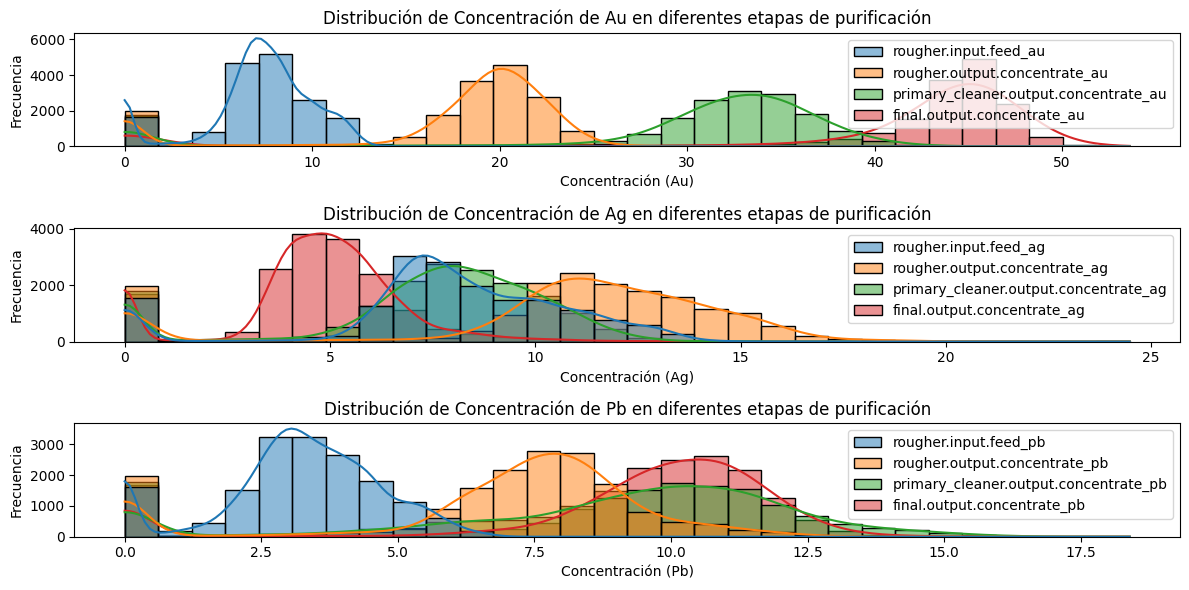

In [15]:
# Visualización de la concentración de Au, Ag, y Pb en diferentes etapas de purificación
# Histograma de la concentración de Au en diferentes etapas de purificación
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
sns.histplot(data=concentration_au, bins=30, color='gold', kde=True)
plt.title('Distribución de Concentración de Au en diferentes etapas de purificación')
plt.ylabel('Frecuencia')
plt.xlabel('Concentración (Au)')

# Histograma de la concentración de Ag en diferentes etapas de purificación
plt.subplot(3, 1, 2)
sns.histplot(data=concentration_ag, bins=30, color='silver', kde=True)
plt.title('Distribución de Concentración de Ag en diferentes etapas de purificación')
plt.ylabel('Frecuencia')
plt.xlabel('Concentración (Ag)')

# Histograma de la concentración de Pb en diferentes etapas de purificación
plt.subplot(3, 1, 3)
sns.histplot(data=concentration_pb, bins=30, color='brown', kde=True)
plt.title('Distribución de Concentración de Pb en diferentes etapas de purificación')
plt.ylabel('Frecuencia')
plt.xlabel('Concentración (Pb)')

plt.tight_layout()
plt.show()

In [16]:
# Comparación de distribuciones del tamaño de las partículas
# Tamaño de partículas en el conjunto de entrenamiento
size_train = train_data['rougher.input.feed_size']

# Tamaño de partículas en el conjunto de prueba
size_test = test_data['rougher.input.feed_size']

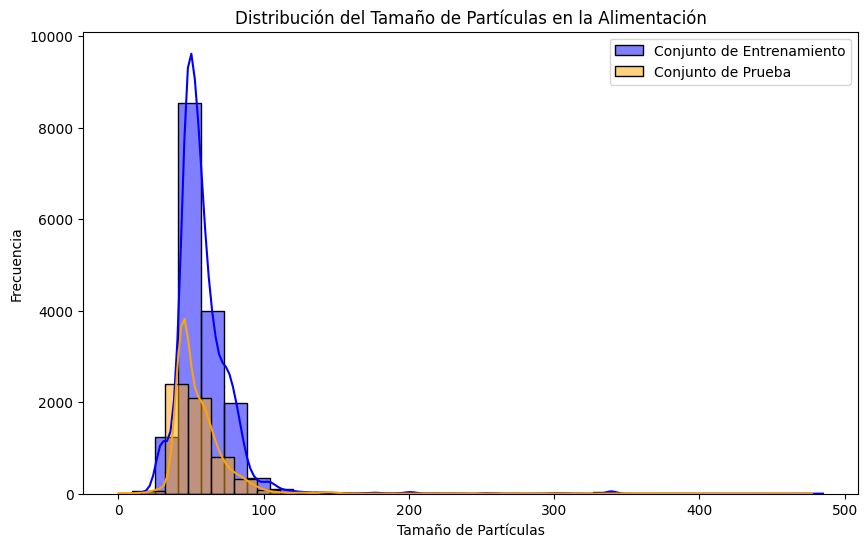

In [17]:
# Creación de histogramas para comparar las distribuciones de tamaño de partículas en ambos conjuntos
# Crea histogramas para comparar las distribuciones
plt.figure(figsize=(10, 6))
sns.histplot(size_train, bins=30, color='blue', label='Conjunto de Entrenamiento', kde=True)
sns.histplot(size_test, bins=30, color='orange', label='Conjunto de Prueba', kde=True)
plt.title('Distribución del Tamaño de Partículas en la Alimentación')
plt.xlabel('Tamaño de Partículas')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

In [18]:
# Análisis de concentraciones totales de sustancias
# Calcula las concentraciones totales en cada etapa
train_data['total_feed'] = train_data.filter(like='input').sum(axis=1)
train_data['total_rougher_concentrate'] = train_data.filter(like='rougher.output.concentrate').sum(axis=1)
train_data['total_final_concentrate'] = train_data.filter(like='final.output.concentrate').sum(axis=1)

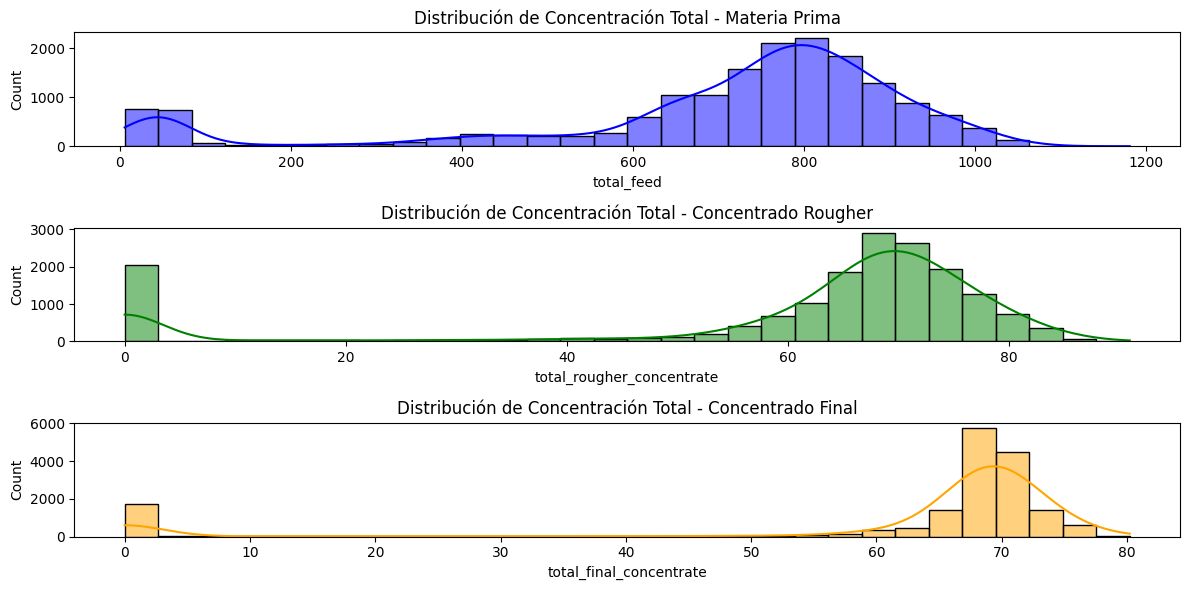

In [19]:
# Crea histogramas para las concentraciones totales en cada etapa
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
sns.histplot(train_data['total_feed'], bins=30, color='blue', kde=True)
plt.title('Distribución de Concentración Total - Materia Prima')

plt.subplot(3, 1, 2)
sns.histplot(train_data['total_rougher_concentrate'], bins=30, color='green', kde=True)
plt.title('Distribución de Concentración Total - Concentrado Rougher')

plt.subplot(3, 1, 3)
sns.histplot(train_data['total_final_concentrate'], bins=30, color='orange', kde=True)
plt.title('Distribución de Concentración Total - Concentrado Final')

plt.tight_layout()
plt.show()

In [20]:
# Define el umbral para eliminar valores atípicos (puedes ajustar este valor según tus necesidades)
umbral_percentil = 99

# Calcula los percentiles para cada etapa
percentile_threshold_feed = np.percentile(train_data['total_feed'], umbral_percentil)
percentile_threshold_rougher = np.percentile(train_data['total_rougher_concentrate'], umbral_percentil)
percentile_threshold_final = np.percentile(train_data['total_final_concentrate'], umbral_percentil)

# Filtra los datos eliminando valores superiores al percentil umbral en cada etapa
train_data_filtered = train_data[
    (train_data['total_feed'] <= percentile_threshold_feed) &
    (train_data['total_rougher_concentrate'] <= percentile_threshold_rougher) &
    (train_data['total_final_concentrate'] <= percentile_threshold_final)
]

# Verifica la forma del conjunto de datos después de la eliminación
print("Forma del conjunto de datos original:", train_data.shape)
print("Forma del conjunto de datos después de la eliminación de valores atípicos:", train_data_filtered.shape)

Forma del conjunto de datos original: (16860, 90)
Forma del conjunto de datos después de la eliminación de valores atípicos: (16367, 90)


In [21]:
# Construcción del modelo
# División del conjunto de entrenamiento
# Divide el conjunto de entrenamiento en subconjuntos de entrenamiento y validación para rougher
X_train_rougher, X_val_rougher, y_train_rougher, y_val_rougher = train_test_split(
    train_data_processed.drop(columns=['date', 'final.output.recovery', 'rougher.output.recovery']),
    train_data['rougher.output.recovery'],
    test_size=0.2,
    random_state=12345
)

# Divide el conjunto de entrenamiento en subconjuntos de entrenamiento y validación para final
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    train_data_processed.drop(columns=['date', 'final.output.recovery', 'rougher.output.recovery']),
    train_data['final.output.recovery'],
    test_size=0.2,
    random_state=12345
)

In [23]:
# Imputación numérica
# Estructura los conjuntos de entrenamiento y validación como DataFrames
# X_train_final sea un DataFrame
X_train_final = pd.DataFrame(X_train_final)
# Obten las columnas de X_train_final
features_train_final = X_train_final.columns.tolist()

# X_train_rougher sea un DataFrame
X_train_rougher = pd.DataFrame(X_train_rougher)

# X_val_rougher sea un DataFrame
X_val_rougher = pd.DataFrame(X_val_rougher)

# Imputación numérica para X_train_rougher
imputer_numeric = SimpleImputer(strategy='mean')
X_train_rougher = pd.DataFrame(imputer_numeric.fit_transform(X_train_rougher), columns=X_train_rougher.columns)
                               
# Imputación numérica para X_val_rougher
X_val_rougher = pd.DataFrame(imputer_numeric.transform(X_val_rougher), columns=X_val_rougher.columns)

# Imputación numérica para X_train_final
X_train_final = pd.DataFrame(imputer_numeric.fit_transform(X_train_final), columns=features_train_final)

In [24]:
# Imputación objetivo
# Reshape de las variables objetivo
y_train_rougher_2d = y_train_rougher.values.reshape(-1, 1)
y_val_rougher_2d = y_val_rougher.values.reshape(-1, 1)
y_train_final_2d = y_train_final.values.reshape(-1, 1)
y_val_final_2d = y_val_final.values.reshape(-1, 1)

# Imputación objetivo para y_train_rougher, y_val_rougher, y_train_final, y_val_final
imputer_target = SimpleImputer(strategy='median')

y_train_rougher = imputer_target.fit_transform(y_train_rougher_2d).flatten()
y_val_rougher = imputer_target.transform(y_val_rougher_2d).flatten()
y_train_final = imputer_target.fit_transform(y_train_final_2d).flatten()
y_val_final = imputer_target.transform(y_val_final_2d).flatten()

In [25]:
# Entrenamiento de modelos
# Entrenamiento de modelos
rf_regressor = RandomForestRegressor(random_state=12345)
linear_regressor = LinearRegression()

In [26]:
# Evaluación mediante validación cruzada
# Evaluación mediante validación cruzada para rougher
smape_rougher_scores = -cross_val_score(rf_regressor, X_train_rougher, y_train_rougher.ravel(), scoring='neg_mean_absolute_error', cv=5)
smape_rougher_avg = np.mean(smape_rougher_scores)

# Evaluación mediante validación cruzada para final
smape_final_scores = -cross_val_score(linear_regressor, X_train_final, y_train_final.ravel(), scoring='neg_mean_absolute_error', cv=5)
smape_final_avg = np.mean(smape_final_scores)

In [27]:
# Funciones para calcular sMAPE
def calculate_smape(y_true, y_pred, epsilon=1e-10):
    denominator = np.abs(y_true) + np.abs(y_pred) + epsilon
    percentage_error = 2 * np.abs(y_pred - y_true) / denominator
    return 100 * np.mean(percentage_error)

# Función para calcular sMAPE final
def calculate_final_smape(smape_rougher, smape_final):
    return 0.25 * smape_rougher + 0.75 * smape_final

In [28]:
# Cálculo de sMAPE
# Entrenamiento y predicciones para la etapa rougher
# Entrenamiento del modelo para la etapa rougher
rf_regressor.fit(X_train_rougher, y_train_rougher)

# Realiza predicciones en el conjunto de prueba para rougher
predictions_rougher = rf_regressor.predict(X_val_rougher)

# Asegúrate de que ambos arrays tengan las mismas dimensiones
y_val_rougher = y_val_rougher[:len(predictions_rougher)]

In [29]:
# Cálculo de sMAPE para rougher
# Realiza predicciones en el conjunto de prueba para rougher
predictions_rougher = rf_regressor.predict(X_val_rougher)

# Calcula el sMAPE para rougher
smape_rougher = calculate_smape(y_val_rougher, predictions_rougher)

In [30]:
# Entrenamiento y predicciones para la etapa final
# Entrena el modelo para la etapa final
rf_regressor.fit(X_train_final, y_train_final)

# Realiza predicciones en el conjunto de prueba para final
predictions_final = rf_regressor.predict(X_val_final)

# Asegúrate de que ambos arrays tengan las mismas dimensiones
y_val_final = y_val_final[:len(predictions_final)]

In [31]:
# Cálculo del sMAPE para final
# Calcula el sMAPE para final
smape_final = calculate_smape(y_val_final, predictions_final)

In [33]:
# Cálcul# Calcula el sMAPE conjunto de prueba
smape_conjunto_prueba = calculate_final_smape(smape_rougher, smape_final)

In [34]:
# Resultados
print(f"sMAPE Rougher: {smape_rougher}")
print(f"sMAPE Final: {smape_final}")
print(f"sMAPE Final (Weighted): {smape_conjunto_prueba:.2f}%")

sMAPE Rougher: 2.155450212123513
sMAPE Final: 2.535162769219685
sMAPE Final (Weighted): 2.44%
